# Agumentation

In [1]:
import torch,random

from torch.nn import init

from n_framework import*
from activations_module import *

In [2]:
clean_mem()

In [3]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import fastcore.all as fc

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim,nn
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:

xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
#dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)
dls = DataLoaders.from_dd(tds, bs)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [6]:
set_seed(42)
lr,epochs=6e-2,5

### Going Wider 
* with the ResNet

In [7]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm = nn.BatchNorm2d):
    layers = [ResBlock(1,16,ks=5, stride=1,act=act,norm=norm)]
    layers += [ResBlock(nfs[i],nfs[i+1],act=act,norm=norm,stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10,bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [8]:
lr=1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra =[BatchschedCB(sched)]
model = get_model(act_gr, norm = nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs = cbs+xtra, opt_func = optim.AdamW)

In [9]:
#learn.fit(6)

- while experimenting with the model, I changed the number of epochs to 6[`prevously was 5`], while running the fit function only without changing the inputs(parameters); as a result the total number of steps (tmax) on the scheduler was affected and gave an error because it was set with the previous num_epochs = 5. 
- Wierdly it started with higher training accuracy of 94.7% and validation accu of 90.4. the training accuracy declined as the model goes to 6 number of epochs, on the fourth epoch it jumped to 95 train_Acc, 92.8 vali_acc. can refer to the above trainig path diagram. 
* I will investigate the reasons of the behavour of the model later 

accuracy,loss,epoch,train
0.826,0.706,0,train
0.861,0.467,0,eval
0.898,0.381,1,train
0.890,0.344,1,eval
0.920,0.267,2,train
0.914,0.277,2,eval
0.942,0.196,3,train
0.925,0.246,3,eval
0.962,0.142,4,train
0.931,0.222,4,eval


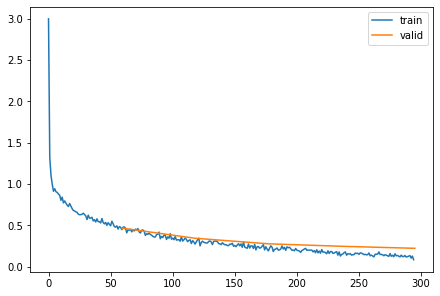

CPU times: user 11min 48s, sys: 1min 30s, total: 13min 18s
Wall time: 4min 4s


In [10]:
%time learn.fit(epochs)

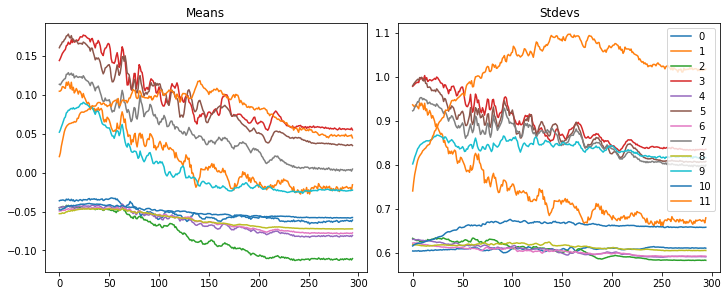

In [11]:

astats.plot_stats()

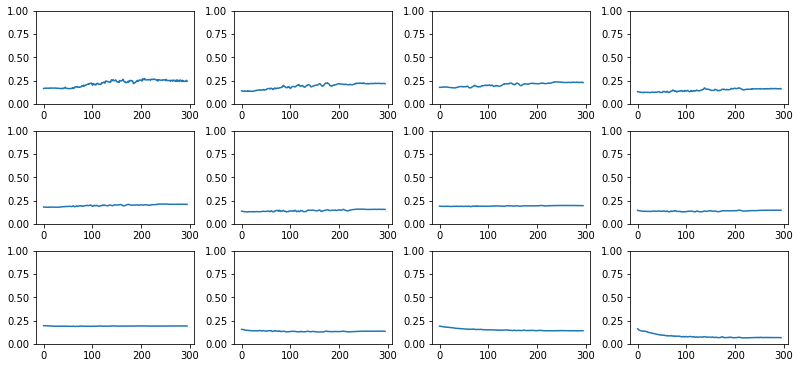

In [12]:
astats.dead_chart()

### Pooling
* Lets add global pooling to the architure to make it flexible

In [13]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [14]:
def get_model2(act=nn.ReLU, nfs = (16,32,64,128,256), norm = nn.BatchNorm2d):
    layers =[ResBlock(1,16, ks=5, stride=1, act=act,norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256,512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512,10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [15]:
#|export
def _flops(x,h,w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w
    raise Exception()
    
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook,mod,inp,outp):
        nonlocal res,totp,totf
        nparams = sum(o.numel() for o in mod.parameters())
        totp += nparams
        *_,h,w = outp.shape
        flops =sum(_flops(o,h,w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1,lr=1, train=False, cbs=SingleBatchCB())
    print(f"Tot_Parameters: {totp} ; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [16]:
TrainLearner(get_model2(),dls,F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot_Parameters: 4904564 ; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6880|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14464|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57600|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229888|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918528|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3672064|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.820,0.726,0,train
0.825,0.594,0,eval
0.899,0.379,1,train
0.898,0.318,1,eval
0.922,0.263,2,train
0.916,0.274,2,eval
0.942,0.197,3,train
0.925,0.240,3,eval
0.961,0.143,4,train
0.933,0.220,4,eval


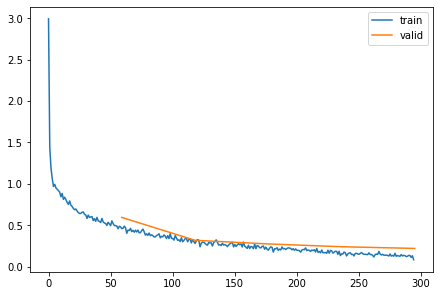

In [17]:
set_seed(42)
model =get_model2(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls,F.cross_entropy,lr=lr, cbs=cbs+xtra,opt_func=optim.AdamW)
learn.fit(epochs)

In [18]:
def get_model3(act=nn.ReLU, nfs = (16,32,64,128,256), norm = nn.BatchNorm2d):
    layers =[ResBlock(1,16, ks=5, stride=1, act=act,norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(),nn.Linear(256,10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [19]:
TrainLearner(get_model3(),dls,F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot_Parameters: 1229940 ; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6880|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14464|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57600|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229888|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918528|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [20]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1])]

In [21]:
[o.shape for o in get_model3()[1].parameters()]

[torch.Size([32, 16, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([32, 16, 1, 1])]

accuracy,loss,epoch,train
0.811,0.750,0,train
0.870,0.453,0,eval
0.898,0.390,1,train
0.893,0.348,1,eval
0.920,0.272,2,train
0.912,0.288,2,eval
0.940,0.204,3,train
0.922,0.251,3,eval
0.960,0.152,4,train
0.930,0.224,4,eval


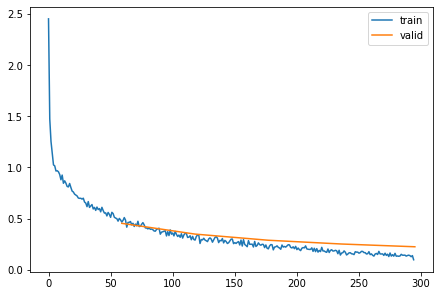

In [22]:
set_seed(42)
model = get_model3(act_gr,norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls,F.cross_entropy,lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [23]:
def get_model4(act=nn.ReLU, nfs = (16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1,16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i],nfs[i+1], stride=2,act=act, norm=norm) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False),nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [24]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot_Parameters: 1223492 ; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|432|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14464|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57600|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|229888|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|918528|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train
0.796,0.799,0,train
0.856,0.494,0,eval
0.895,0.400,1,train
0.894,0.376,1,eval
0.916,0.284,2,train
0.908,0.284,2,eval
0.937,0.213,3,train
0.919,0.265,3,eval
0.959,0.156,4,train
0.923,0.242,4,eval


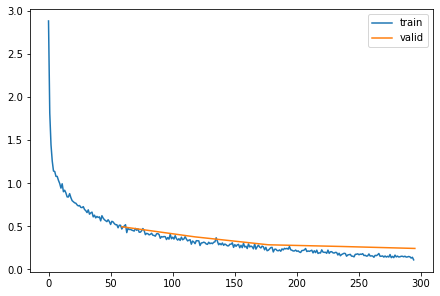

CPU times: user 10min 41s, sys: 1min 17s, total: 11min 59s
Wall time: 3min 40s


In [25]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs = cbs+xtra, opt_func=optim.AdamW)
%time learn.fit(epochs)

In [26]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]), torch.Size([16]), torch.Size([16])]

In [27]:
[o.shape for o in get_model2()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1])]

### Data Augumentation

In [28]:
from torchvision import transforms

In [29]:
#|export
class BatchTransformCB(callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
        
    def before_batch(self,learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [30]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28,padding=4),
                    transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model4()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs = [DeviceCB(),SingleBatchCB(), augcb])

In [31]:
clean_mem()

In [32]:
learn.fit(1)

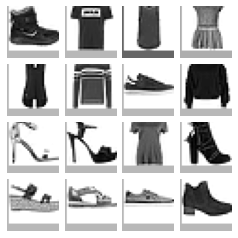

In [33]:
xb,yb =learn.batch
show_images(xb[:16], imsize=0.8)

In [34]:
tfms = nn.Sequential(transforms.RandomCrop(28,padding=2),
                    transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.723,0.997,0,train
0.814,0.658,0,eval
0.846,0.639,1,train
0.846,0.533,1,eval
0.872,0.505,2,train
0.861,0.450,2,eval
0.882,0.412,3,train
0.808,0.634,3,eval
0.896,0.342,4,train
0.876,0.364,4,eval


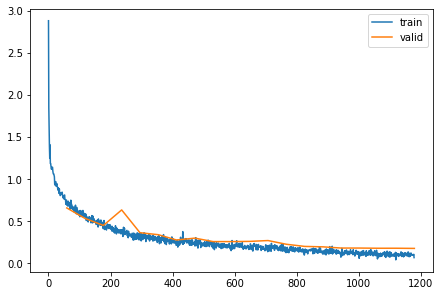

CPU times: user 42min 36s, sys: 5min 30s, total: 48min 6s
Wall time: 14min 55s


In [35]:
set_seed(42)
epochs=20
lr =1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchschedCB(sched), augcb]
model = get_model4(act_gr, norm= nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs= cbs+xtra, opt_func=optim.AdamW)
%time learn.fit(epochs)

In [36]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_augument_20_epochs.pkl')

accuracy,loss,epoch,train
0.718,1.009,0,train
0.808,0.692,0,eval
0.836,0.690,1,train
0.859,0.588,1,eval
0.867,0.582,2,train
0.868,0.520,2,eval
0.881,0.507,3,train
0.876,0.455,3,eval
0.890,0.444,4,train
0.875,0.434,4,eval


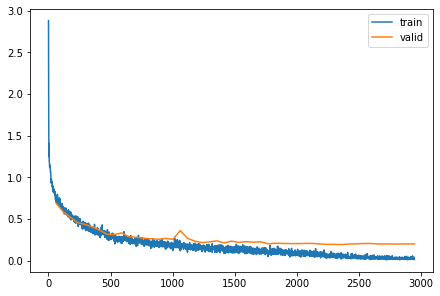

CPU times: user 1h 43min 19s, sys: 13min 52s, total: 1h 57min 11s
Wall time: 36min 56s


In [37]:
set_seed(42)
epochs=50
lr =1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchschedCB(sched), augcb]
model = get_model4(act_gr, norm= nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs= cbs+xtra, opt_func=optim.AdamW)
%time learn.fit(epochs)

#### Personal Note overview
- I think here the model is overfitting, with train accuracy of 99.5 and val accu of 94.3. Even tho we are using some data augumentation [Randome croping of padding 1 and randome horizontal flipping]to keep it from overfitting
* we will add dropout to reduce the overfitting.
* i found out that macbook m1 with 16 Ram has faster GPU training time than paperspaces Free PS5000 with 30 GiB Ram |8 CPU | 16 GiB GPU.  | Free A4000 with 45 GiB Ram | 8 CPU | 16 GiB GPU
compared with 58 minutes 5 s wall time over 1h 5min 27s paperspace walltime on the 50 epochs training and  
""............23 min 41s MAC M1 wall time over 25 min 10s training wall time on the 20 epochs  
 ""...........14 min 55s  ...............".............................on the 20 epochs. 
 " ...........36 min 56s .................over 58 min 5s ....................on the 50 epochs.

- Paperspace Free A4000 is almost twice faster


### Test Time Augumentation (TTA)

In [38]:
#|export
class CapturePreds(callback):
    def before_fit(self,learn): self.learn

## Dropout

In [39]:
p = 0.1
dist = distributions.binomial.Binomial(probs= 1 - p)
dist.sample((25,))

tensor([0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
class Dropout(nn.Module):
    def __init__(self, p =0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.).to(x.device), probs = (1 - self.p))
        return x * dist.sample(x.size()) * 1/(1 - self.p)

In [41]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm = nn.BatchNorm2d, drop =0.0):
    layers = [ResBlock(1,16, act=act,norm=norm, stride=1, ks=5), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias =False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [44]:
set_seed(42)
lr,epochs = 1e-2,20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=tmax)
xtra = [BatchschedCB(sched)]
model = get_dropmodel(act_gr, norm = nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs= cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.801,0.801,0,train
0.864,0.551,0,eval
0.890,0.517,1,train
0.885,0.435,1,eval
0.905,0.408,2,train
0.891,0.381,2,eval
0.912,0.326,3,train
0.899,0.332,3,eval
0.919,0.274,4,train
0.903,0.295,4,eval


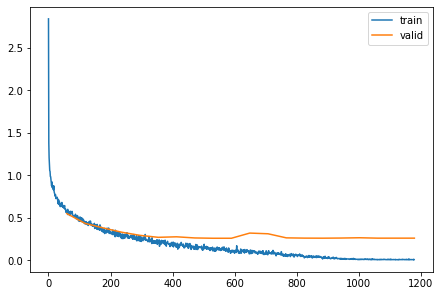

CPU times: user 51min 20s, sys: 6min 38s, total: 57min 58s
Wall time: 17min 32s


In [45]:
%time learn.fit(epochs)

In [48]:
set_seed(42)
lr,epochs = 1e-2,20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr = lr, total_steps=tmax)
xtra = [BatchschedCB(sched)]
model = get_dropmodel(act_gr, norm = nn.BatchNorm2d, drop=0.5).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs= cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.722,0.994,0,train
0.833,0.570,0,eval
0.859,0.603,1,train
0.864,0.480,1,eval
0.884,0.463,2,train
0.888,0.366,2,eval
0.897,0.369,3,train
0.902,0.308,3,eval
0.908,0.307,4,train
0.901,0.301,4,eval


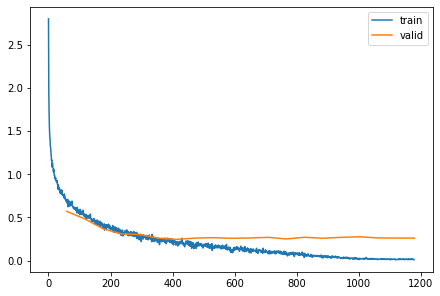

CPU times: user 51min, sys: 6min 36s, total: 57min 37s
Wall time: 17min 22s


In [49]:
%time learn.fit(epochs)

The model here is overfitting even after using dropout method [even with drop=0.5], with try other augumentations methods  N.B this dropout model is used with only randomeHorizontalfliping and RandomeCropping with padding of 2 